# How the Scientific Python ecosystem helps answering fundamental questions of the Universe

The ATLAS experiment at CERN explores vast amounts of physics data to answer the most fundamental questions of the Universe.

* What is Dark Matter, and can we produce dark matter particles in the LHC?
* Are there extra spatial dimensions beyond the familiar three?
* Why is there more matter than antimatter in the universe?
* Are there new fundamental particles or forces?
* ...

The Large Hadron Collider (LHC) is a circular particle accelerator that provides high energy proton-proton collisions (_events_), from which new particles are being produced due to the basic equation that relates energy and matter:  
$$E = mc^2$$

![](figures/LHC_collisions.jpeg)

The ATLAS detector is mounted in one of the four interaction points of the LHC -- other detectors are mounted in other interaction points.

![](figures/LHC.png)

Those outgoing, newly produced particles, leave signatures in the ATLAS detector. Physicists reconstruct particle objects from those signatures.

ATLAS is a complex detector, composed by various sub-detectors, each one specialized to the detection of a specific signature/particle.

![](figures/ATLASImage.jpg)

![](figures/Schematic-of-how-different-particles-interact-with-the-ATLAS-detector.png)

Those reconstructed particle objects, after various processing and data reduction steps, are stored in a compact data format called _PHYSLITE_ ($\sim 10\,\text{kB/event}$). Physicists analyze PHYSLITE data to study the properties of the particles produced in each event.

PHYSLITE data are highly structured and can be represented in a tabular format. However, since each event can contain variable number of particles, this will be a _jagged_ table. Learn more about [jagged data](https://en.wikipedia.org/wiki/Jagged_array) in the Part 3 of the tutorial [Thinking In Arrays](https://github.com/ekourlit/scipy2024-tutorial-thinking-in-arrays).

There is a specialized Python library that provides NumPy-like idioms for arbitrary data structures that we will utilize. The [Awkward Array](https://github.com/scikit-hep/awkward). For example:

In [32]:
import awkward as ak

example = ak.Array([
    [{"x": 1.1, "y": 1.2, "z": 3.1}, {"x": 2.2, "y": 1.3, "z": 2}, {"x": 3.3, "y": 2.4, "z": 4.2}],     # this event contains three electrons with properties x, y, and z
    [],                                                                                                 # this event contains no electrons
    [{"x": 4.4, "y": 1.1, "z": 1}, {"x": 5.5, "y": 4.2, "z": 3.2}]                                      # this event contains two electrons with properties x, y, and z
])

ak.to_dataframe(example)

x    y    z
entry subentry               
0     0         1.1  1.2  3.1
      1         2.2  1.3  2.0
      2         3.3  2.4  4.2
2     0         4.4  1.1  1.0
      1         5.5  4.2  3.2

What is well defined are the properties of the particles we store in PHYSLITE files. Those are all listed in:

https://atlas-physlite-content-opendata.web.cern.ch/

ATLAS has recently released 65 TB of PHYSLITE open data for research -- this is over 7 billion LHC collision events! Those are all the data collected by the experiment during the 2015 and 2016. The release is accompanied by additional 2 billion events of simulated “Monte Carlo” data, which are essential for carrying out a physics analysis. We're going to use these simulated events for today's demonstration for practical purposes.

Find more information about our open data release at: 

https://atlas.cern/Updates/News/Open-Data-Research

## Import the required libraries

In [1]:
import coffea
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools
from matplotlib import pyplot as plt
import numpy as np
import hist
import dask

In [2]:
print("coffea version: ", coffea.__version__)
print("awkward version: ", ak.__version__)
print("dask version: ", dask.__version__)

coffea version:  2024.5.0
awkward version:  2.6.4
dask version:  2024.5.2


The data we will use for this demonstration are simulated data but have the exact same structure and properties as the real data collected from the experiment.

The particular case we will use is the search for the Higgs boson, an elementary particle discovered in 2012. The Higgs boson was predicted by the BEH mechanism, the mechanism that explains how all the particles in the Universe acquire mass. The discovery of the Higgs boson by the ATLAS and CMS experiments at CERN awarded the Nobel prize for physics to Francois Englert and Peter W. Higgs in 2013. 

The Higgs boson is produced by the proton-proton collisions of the LHC. However, it is extremely short lived (about $10^{-22}$ seconds) and immediately decays to other particles. For this scenario we will study the decays of the Higgs boson to two other elementary particles, the Z bosons. In their turn, Z bosons are extremely short lived as well but they can decay at about 3% of the time to two electrons. Electrons are also elementary particle but stable ones! Therefore we will look at our detector for electron signatures. In particular four electrons.

![Alt text](figures/fig_01d.png)

In [3]:
# Hgg -> 4l sample

# local
file_path = '/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1'

# UChicago
# file_path = 'root://xcache.af.uchicago.edu:1094//root://eosuser.cern.ch//eos/user/e/ekourlit/public/scipy_ATLAS_demo/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/DAOD_PHYSLITE.38191712._000001.pool.root.1'

In [4]:
events = NanoEventsFactory.from_root(
    {file_path: "CollectionTree"},
    schemaclass=PHYSLITESchema
).events()

/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/nanoevents/methods/physlite.py:10: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import base, vector
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:226: UserWarning: Skipping xTrigDecisionAux. as it is not interpretable by Uproot
  warnings.warn(
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:234: UserWarning:

# Highly structured jagged data

In [5]:
events.fields

['xTrigDecision',
 'METAssoc_MET',
 'AntiKt10TruthSoftDropBeta100Zcut10Jets',
 'AntiKt10UFOCSSKJets',
 'AntiKt4TruthDressedWZJets',
 'TrigConfKeys',
 'index_ref',
 'Electrons',
 'Jets',
 'Photons',
 'TauJets',
 'TrigMatch_HLT_e5_lhvloose',
 'TrigMatch_HLT_e5_lhvloose_nod0',
 'BTagging_AntiKt4EMPFlow',
 'BTagging_AntiKtVR30Rmax4Rmin02Track',
 'BornLeptons',
 'CombinedMuonTrackParticles',
 'EventInfo',
 'ExtrapolatedMuonTrackParticles',
 'GSFTrackParticles',
 'HardScatterParticles',
 'HardScatterVertices',
 'InDetTrackParticles',
 'Kt4EMPFlowEventShape',
 'MET_Core_MET',
 'MET_Truth',
 'MuonSpectrometerTrackParticles',
 'PrimaryVertices',
 'TauTracks',
 'TruthBoson',
 'TruthBosonsWithDecayParticles',
 'TruthBosonsWithDecayVertices',
 'TruthElectrons',
 'TruthEvents',
 'TruthPhotons',
 'TruthPrimaryVertices',
 'egammaClusters',
 'Muons',
 'TrigMatch_HLT_mu10',
 'TrigMatch_HLT_mu14',
 'TrigMatch_HLT_mu18',
 'TrigMatch_HLT_mu20',
 'TrigMatch_HLT_mu20_iloose_L1MU15',
 'TrigMatch_HLT_mu22',
 

In [6]:
events.Electrons.compute()

<ElectronArray [[{trackParticleLinks: ..., ...}], ...] type='40000 * var * ...'>

# Data selection and feature engineering

In [7]:
def object_selection(events):
    '''
    Select objects based on kinematic and quality criteria
    '''
    
    electrons = events.Electrons
    muons = events.Muons
    
    electron_reqs = (electrons.pt > 20) & \
                    (np.abs(electrons.eta) < 2.47) & \
                    (electrons.DFCommonElectronsLHLoose == 1) & \
                    (electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000/electrons.pt < 0.15) & \
                    (electrons.topoetcone20/electrons.pt < 0.2)
                    
    # add quality requirements here
    muon_reqs = (muons.pt > 20) & \
                (np.abs(muons.eta) < 2.7) & \
                (muons.quality == 2) & \
                (muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000/muons.pt < 0.15) & \
                (muons.topoetcone20/muons.pt < 0.3)
    
    # only keep objects that pass our requirements
    electrons = electrons[electron_reqs]
    muons = muons[muon_reqs]
    
    return electrons, muons

def region_selection(electrons, muons):
    '''
    Select events based on object multiplicity
    '''
    
    selections = PackedSelection(dtype='uint64')
    # basic selection criteria
    selections.add("exactly_4e", ak.num(electrons) == 4)
    selections.add("total_e_charge_zero", ak.sum(electrons.charge, axis=1) == 0)
    selections.add("exactly_0m", ak.num(muons) == 0)
    # selection criteria combination
    selections.add("4e0m", selections.all("exactly_4e", "total_e_charge_zero", "exactly_0m"))
    
    return selections.all("4e0m")

def calculate_inv_mass(electrons):
    '''
    Construct invariant mass observable
    '''
    
    # reconstruct Higgs as 4e system
    candidates = ak.combinations(electrons, 4)
    e1, e2, e3, e4 = ak.unzip(candidates)
    candidates["p4"] = e1 + e2 + e3 + e4
    higgs_mass = candidates["p4"].mass
    observable = ak.flatten(higgs_mass/1000)
    
    return observable

In [8]:
# select objects and events
el, mu = object_selection(events)
selection_4e0m = region_selection(el, mu)

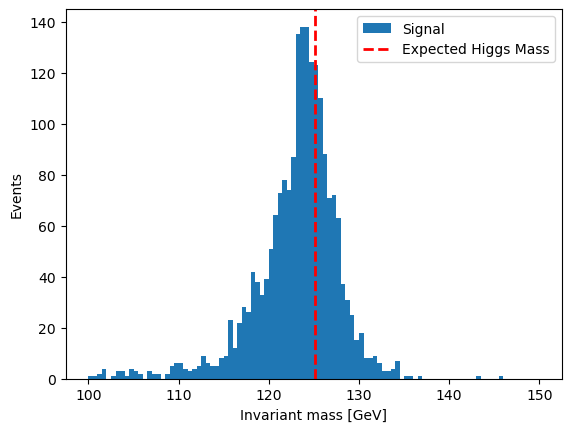

In [9]:
# observable calculation and plotting
plt.hist(calculate_inv_mass(el[selection_4e0m]).compute(), bins=100, range=(100, 150), label='Signal')
plt.axvline(125.11, color='r', linestyle='dashed', linewidth=2, label='Expected Higgs Mass')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()

# Scale out processing over multiple files

In [10]:
# local
fileset = {"ZZ"     : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.700600.Sh_2212_llll.deriv.DAOD_PHYSLITE.e8433_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.37110926._000047.pool.root.1' : "CollectionTree"},
                      'metadata': {'process': 'ZZ', 'xsec': 1.2973999999999999, 'nevts': 67558600}},
           "Higgs"  : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1' : "CollectionTree"}, 
                      'metadata': {'process': 'Higgs', 'xsec': 28.299999999999997, 'nevts': 6500000}},}

# UChicago
# fileset = {"ZZ"     : {'files': {'root://xcache.af.uchicago.edu:1094//root://eosuser.cern.ch//eos/user/e/ekourlit/public/scipy_ATLAS_demo/mc20_13TeV.700600.Sh_2212_llll.deriv.DAOD_PHYSLITE.e8433_s3681_r13167_p6026' : "CollectionTree"},
#                       'metadata': {'process': 'ZZ', 'xsec': 1.2973999999999999, 'nevts': 67558600}},
#            "Higgs"  : {'files': {'root://xcache.af.uchicago.edu:1094//root://eosuser.cern.ch//eos/user/e/ekourlit/public/scipy_ATLAS_demo/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026' : "CollectionTree"}, 
#                       'metadata': {'process': 'Higgs', 'xsec': 28.299999999999997, 'nevts': 6500000}},}

# pre-process
samples, _ = dataset_tools.preprocess(fileset)

In [11]:
# create histogram with observables
def create_histogram(events):
    hist_4e0m = (
        hist.dask.Hist.new.Reg(100, 100, 150, name='m_eeee', label=r"$m_{eeee}$ [GeV]")
        .StrCat([], name='process', label='Process', growth=True)
        .Weight()
    )

    process = events.metadata['process']

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 36000. # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1
        
    print(f"Processing {process} with xsec weight {xsec_weight}")

    # select objects and events
    el, mu = object_selection(events)
    selection_4e0m = region_selection(el, mu)

    # observable calculation and histogram filling
    inv_mass = calculate_inv_mass(el[selection_4e0m])
    hist_4e0m.fill(inv_mass, weight=xsec_weight, process=process)

    return {"4e0m": hist_4e0m}

In [12]:
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema)

Processing ZZ with xsec weight 0.0006913464755042288
Processing Higgs with xsec weight 0.15673846153846152


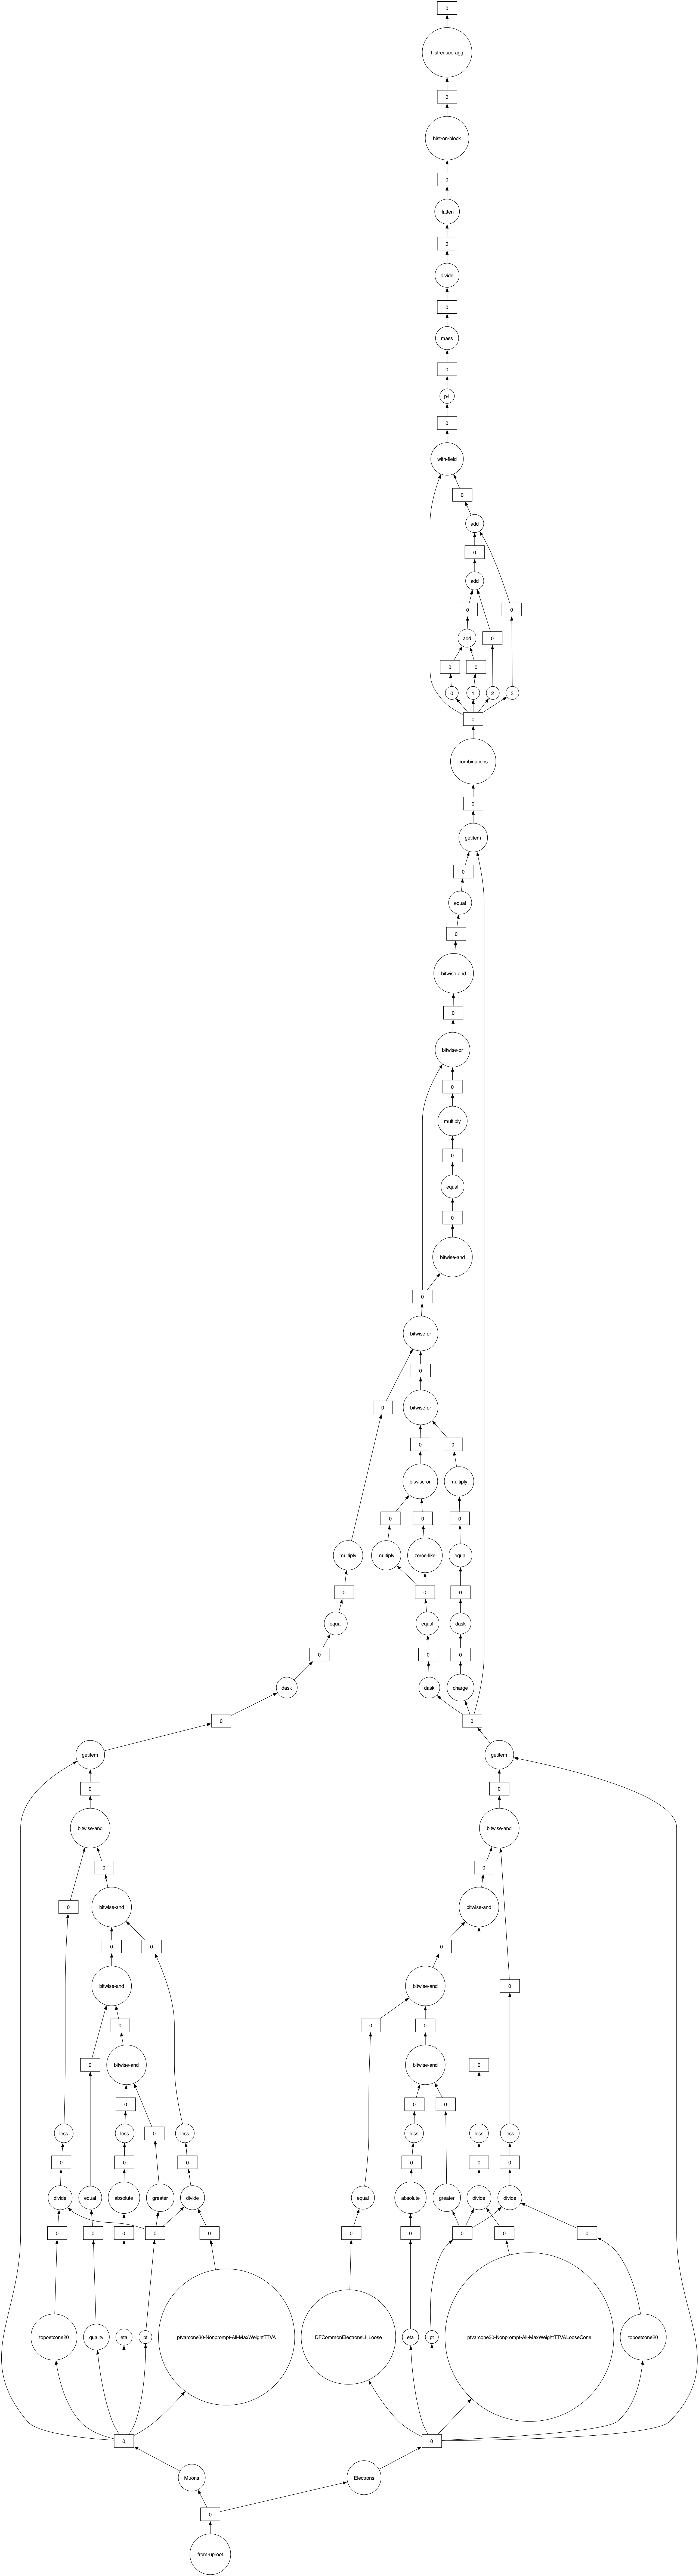

In [13]:
# visualise the task graph
tasks["Higgs"]["4e0m"].visualize()

In [14]:
%%time
# execute
(out, ) = dask.compute(tasks)

CPU times: user 5.54 s, sys: 157 ms, total: 5.7 s
Wall time: 5.68 s


In [15]:
# stack all the histograms together, as we processed each sample separately
full_histogram = sum([v["4e0m"] for v in out.values()])

Text(0, 0.5, 'Events')

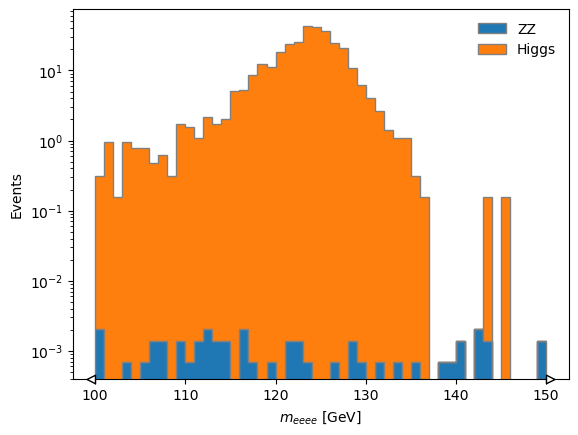

In [18]:
artists = full_histogram[hist.rebin(2), :].stack("process").plot(
    stack=True, histtype="fill", linewidth=1, edgecolor="grey")

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_yscale("log")
ax.set_ylabel("Events")